In [1]:
import matplotlib.pyplot as plt



In [2]:
pip install pyDOE

Note: you may need to restart the kernel to use updated packages.


# All constants
Assumption : tissue as a single layer(l1) of same depth

In [3]:
#laser power
P = 6.4
# time for the simulation

sim_time = 10 # seconds

#shape of the tissue

length = 10 # mm
width = 10  # mm
depth = 12.08 # mm

sigma = 1 # Standard devaition of Laser beam width (mm)

#for layer l1 : Epidermis layer

l1 = 0.08 # thickness of the layer(mm)
rho1 = 0.0012 # density thickness of the layer (g/mm^3)
C1 = 3.6 # specific heat (J/g. deg Celsius)
Cb1 = 4.2 # specific heat of the blood (J/g. deg Celsius)
K1 = 0.00026 # thermal conductivity of the tissue (W/mm. deg Celsius)
Wb1 = 0 # Blood perfusion rate (g/mm^3. s)
alpha1 = 0.1 #laser absorbtivity of the first layer
Reff1 = 0.93 # Laser reflectivity of the first layer 
Q1 = lambda x,y,z : (1/(2*torch.pi*sigma**2))*alpha1*torch.exp(-alpha1*z)*torch.exp(-1*(x**2+y**2)/(2*sigma**2))*P*(1-Reff1) #Volumetric heat due to spatial heating

#for layer l2 : Dermis layer

l2 = 2 # thickness of the layer(mm)
rho2 = 0.0012 # density thickness of the layer (g/mm^3)
C2 = 3.4 # specific heat (J/g. deg Celsius)
Cb2 = 4.2 # specific heat of the blood (J/g. deg Celsius)
K2 = 0.00052 # thermal conductivity of the tissue (W/mm. deg Celsius)
Wb2 = 5 * 10**(-7) # Blood perfusion rate (g/mm^3. s)
alpha2 = 0.08 #laser absorbtivity of the first layer
Reff2 = 0.93 # Laser reflectivity of the first layer 
Q2 = lambda x,y,z : (1/(2*torch.pi*sigma**2))*alpha2*torch.exp(-alpha1*rho1)*torch.exp(-alpha2*z)*torch.exp(-1*(x**2+y**2)/(2*sigma**2))*P*(1-Reff2) #Volumetric heat due to spatial heating

#for layer l3 : Subcutaneous layer

l3 = 10 # thickness of the layer(mm)
rho3 = 0.001 # density thickness of the layer (g/mm^3)
C3 = 3.06 # specific heat (J/g. deg Celsius)
Cb3 = 4.2 # specific heat of the blood (J/g. deg Celsius)
K3 = 0.00021 # thermal conductivity of the tissue (W/mm. deg Celsius)
Wb3 = 5 * 10**(-7) # Blood perfusion rate (g/mm^3. s)
alpha3 = 0.04 #laser absorbtivity of the first layer
Reff3 = 0.93 # Laser reflectivity of the first layer 
Q3 = lambda x,y,z : (1/(2*torch.pi*sigma**2))*alpha3*torch.exp(-alpha1*rho1)*torch.exp(-alpha2*rho2)*torch.exp(-alpha3*z)*torch.exp(-1*(x**2+y**2)/(2*sigma**2))*P*(1-Reff3) #Volumetric heat due to spatial heating

Sequential(
  (0): Linear(in_features=4, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=1, bias=True)
)
model parameters on gpu: False
Epoch (Adam): 0, Cost: 51.71000671386719, Bound_loss: 16.751781463623047, Fun_loss: 18.31483268737793
Epoch (Adam): 100, Cost: 0.3216000199317932, Bound_loss: 0.19711212813854218, Fun_loss: 0.11602898687124252
Epoch (Adam): 200, Cost: 0.13911263644695282, Bound_loss: 0.08422531932592392, Fun_loss: 0.05238580331206322
Epoch (Adam): 300, Cost: 0.08161290735006332, Bound_loss: 0.05026731640100479, Fun_loss: 0.03037801943719387
Epoch (Adam): 400, Cost: 0.05540970712900162, Bound_loss: 0.03440151363611221, Fun_loss: 0.020451625809073448
Epoch (Adam): 500, Cost: 0.04029028117656708, Bound_loss: 0.025084469467401505, Fun_loss: 0.014825941994786263
Epoch (Adam): 600, Cost: 0.0304604

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


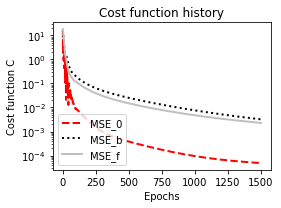

In [4]:
import time
import torch
import numpy as np
import scipy.io
from pyDOE import lhs
from physicsinformed import PhysicsInformedContinuous
from scipy.interpolate import griddata
import utilities

# Select gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

# Set seed for the Random Number Generator (RNG), setting the seed generates same set of random numbers everytime 
torch.manual_seed(0)
np.random.seed(0) 

# Define no. of training points
N0 = 100 # intial values at t = 0 (0,x,y,z)
N_b = 50
N_f = 20000

# Define feed-forward network architecture
layers = [4, 20, 20, 20, 1]

# Define no. of epochs for each optimizer
epochs_Adam = 1500
epochs_LBFGS = 1000

### PRE-PROCESSING ###
'''# Loading benchmark data
data = scipy.io.loadmat('heat1Dscript.mat')
t = data['ts'].flatten()[:, None]
x = data['xs'].flatten()[:, None]
u_sol = data['usol'].T
flux_sol = data['fluxsol'].T'''

#X, T = np.meshgrid(x, t) # Creates mesh such that for every xi, all the ti s can be accessed and vice-versa

# Domain bounds
lb = np.array([0,0,0,0])  # minimum(t,x,y,z)
ub = np.array([sim_time,length,width,depth]) # maximum(t,x,y,z)

lic  = [l1*10**(-3),(l1+l2)*10**(-3),(l1+l2+l3)*10**(-3)] #layer_interface_coordinates

'''
#z coordinates for different layers of the tissue (for layer1,layer2 and layer3)
lic  = [l1,l1+l2,l1+l2+l3] ''''layer_interface_coordinates''''
z_l1 = lb[3] + (lic[0] - lb[3]) * lhs(1, no_of_points_req) 
z_l2 = l[0] + (lic[1] - l[0]) * lhs(1, no_of_points_req)
z_l3 = l[1] + (lic[2] - l[1]) * lhs(1, no_of_points_req)
'''

# Create collocation points with latin hypercube sampling
txyz_f = lb + (ub - lb) * lhs(4, N_f) # Creates 20000 sample points in x, y, z and t


# Transform grid into vectors that can be processed by the neural net
'''X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None])) #Stack arrays in sequence horizontally (column wise)
u_star = u_sol.flatten()[:, None]
flux_star = flux_sol.flatten()[:, None]
'''


# Select random data points for the initial condition
id_rand = np.random.choice(txyz_f.shape[0], N0, replace=False) # Choose random 100 indices from 256 total indices of space
x0 = txyz_f[:,1:2][id_rand, :] # location of these 100 random points
y0 = txyz_f[:,2:3][id_rand, :]
z0 = txyz_f[:,3:4][id_rand, :]
xyz0 = np.concatenate((0 * x0, x0, y0, z0), 1) # (0,x0,y0,z0) initial condition

# Select random data points for the boundary condition

# for z= 0 => (t,x,y,0)
id_tb = np.random.choice(txyz_f.shape[0], N_b, replace=False) # Choose random 50 indices from 201 total indices of time
tb = txyz_f[:,0:1][id_tb, :] # time stamps of those 50 indices
id_xb = np.random.choice(txyz_f.shape[0], N_b, replace=False)
xb = txyz_f[:,1:2][id_xb, :]
id_yb = np.random.choice(txyz_f.shape[0], N_b, replace=False)
yb = txyz_f[:,2:3][id_yb, :]

txy0b = np.concatenate((tb, xb, yb, 0*tb), 1)  # for calculating error for this cond>>add error term 3times for
                                               # 3 layers with different parameters

    
# for the lateral surfaces (boundary conditions)

# x-z plane -> ((t,x,y_lb,z) & (t,x,y_ub,z))
id_x_lat = np.random.choice(txyz_f.shape[0], N_b, replace=False) #coordinates for lateral surfaces
x_xz_ = txyz_f[:,1:2][id_x_lat, :]
id_y_lat = np.random.choice(txyz_f.shape[0], N_b, replace=False)
y_xz_ = txyz_f[:,2:3][id_y_lat, :]
id_z_lat = np.random.choice(txyz_f.shape[0], N_b, replace=False)
z_xz_ = txyz_f[:,3:4][id_y_lat, :]
xz_lb = np.concatenate((tb, x_xz_, 0 * tb + lb[2], z_xz_ ), 1) # (t,x,lb[0],z)  
xz_ub = np.concatenate((tb, x_xz_, 0 * tb + ub[2], z_xz_ ), 1) # (t,x,ub[0],z)

# y-z plane -> ((t,x_lb,y,z) & (t,x_ub,y,z))

yz_lb = np.concatenate((tb,0 * tb + lb[1],y_xz_,z_xz_ ), 1) # (tb,lb[1],y,z)  
yz_ub = np.concatenate((tb,0 * tb + ub[1],y_xz_,z_xz_ ), 1) # (tb,ub[1],y,z)

## input data for the interfaces between the layers (@ l1 ,@ l1+l2 ,@ l1+l2+l3)

id_t_int = np.random.choice(txyz_f.shape[0], N_b, replace=False) # Choose random 50 indices from 20000 total indices 
t_int_ = txyz_f[:,0:1][id_t_int, :] # time stamps of those 50 indices
id_x_int = np.random.choice(txyz_f.shape[0], N_b, replace=False)
x_int_ = txyz_f[:,1:2][id_x_int, :]
id_y_int = np.random.choice(txyz_f.shape[0], N_b, replace=False)
y_int_ = txyz_f[:,2:3][id_y_int, :]

txyz_int_l1 = np.concatenate((t_int_, x_int_, y_int_, 0 * t_int_ + lic[0] ), 1)
txyz_int_l2 = np.concatenate((t_int_, x_int_, y_int_, 0 * t_int_ + lic[1] ), 1)
txyz_int_l3 = np.concatenate((t_int_, x_int_, y_int_, 0 * t_int_ + lic[2] ), 1)


### TRAINING ###
# Create torch.tensors of training data

#for the initial condition at t=0 # we will have to consider all 3 layers if assumption is removed

t_0 = torch.tensor(xyz0[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_0 = torch.tensor(xyz0[:, 1:2], dtype=dtype, requires_grad=True, device=device)
y_0 = torch.tensor(xyz0[:, 2:3], dtype=dtype, requires_grad=True, device=device)
z_0 = torch.tensor(xyz0[:, 3:4], dtype=dtype, requires_grad=True, device=device)

#for the surface boundary condition -> z=0

t_b = torch.tensor(txy0b[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_b = torch.tensor(txy0b[:, 1:2], dtype=dtype, requires_grad=True, device=device)
y_b = torch.tensor(txy0b[:, 2:3], dtype=dtype, requires_grad=True, device=device)
z_b = torch.tensor(txy0b[:, 3:4], dtype=dtype, requires_grad=True, device=device)


#for the lateral boundary condition -> lateral surafces x-z and y-z planes # we need to consider all 3 layers if assumption is removed

t_xz_lb = torch.tensor(xz_lb[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_xz_lb = torch.tensor(xz_lb[:, 1:2], dtype=dtype, requires_grad=True, device=device)
y_xz_lb = torch.tensor(xz_lb[:, 2:3], dtype=dtype, requires_grad=True, device=device)
z_xz_lb = torch.tensor(xz_lb[:, 3:4], dtype=dtype, requires_grad=True, device=device)

t_xz_ub = torch.tensor(xz_ub[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_xz_ub = torch.tensor(xz_ub[:, 1:2], dtype=dtype, requires_grad=True, device=device)
y_xz_ub = torch.tensor(xz_ub[:, 2:3], dtype=dtype, requires_grad=True, device=device)
z_xz_ub = torch.tensor(xz_ub[:, 3:4], dtype=dtype, requires_grad=True, device=device)


t_yz_lb = torch.tensor(yz_lb[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_yz_lb = torch.tensor(yz_lb[:, 1:2], dtype=dtype, requires_grad=True, device=device)
y_yz_lb = torch.tensor(yz_lb[:, 2:3], dtype=dtype, requires_grad=True, device=device)
z_yz_lb = torch.tensor(yz_lb[:, 3:4], dtype=dtype, requires_grad=True, device=device)

t_yz_ub = torch.tensor(yz_ub[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_yz_ub = torch.tensor(yz_ub[:, 1:2], dtype=dtype, requires_grad=True, device=device)
y_yz_ub = torch.tensor(yz_ub[:, 2:3], dtype=dtype, requires_grad=True, device=device)
z_yz_ub = torch.tensor(yz_ub[:, 3:4], dtype=dtype, requires_grad=True, device=device)

# for the interfaces between the layers (@ l1 ,@ l1+l2 ,@ l1+l2+l3) but for our assumption we take single layer

t_int = torch.tensor(t_int_, dtype=dtype, requires_grad=True, device=device)
x_int = torch.tensor(x_int_, dtype=dtype, requires_grad=True, device=device)
y_int = torch.tensor(y_int_, dtype=dtype, requires_grad=True, device=device)

#for layer 3 (if we consider only single layer, this z will be used for training)

z_int_l3 = torch.tensor(0 * t_int_ + lic[2] , dtype=dtype, requires_grad=True, device=device)

#for layer 2

z_int_l2 = torch.tensor(0 * t_int_ + lic[1] , dtype=dtype, requires_grad=True, device=device)

#for layer 1

z_int_l1 = torch.tensor(0 * t_int_ + lic[0] , dtype=dtype, requires_grad=True, device=device)

# for the functional error
t_f = torch.tensor(txyz_f[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_f = torch.tensor(txyz_f[:, 1:2], dtype=dtype, requires_grad=True, device=device)
y_f = torch.tensor(txyz_f[:, 2:3], dtype=dtype, requires_grad=True, device=device)
z_f = torch.tensor(txyz_f[:, 3:4], dtype=dtype, requires_grad=True, device=device)

# Initialize PINN model
PINNModel = PhysicsInformedContinuous(layers, t_0,x_0,y_0,z_0, t_b, x_b, y_b, z_b, t_xz_lb,x_xz_lb,y_xz_lb,z_xz_lb, t_xz_ub,x_xz_ub,
                                      y_xz_ub,z_xz_ub, t_yz_lb,x_yz_lb,y_yz_lb,z_yz_lb, t_yz_ub,x_yz_ub,
                                      y_yz_ub,z_yz_ub, t_int, t_f, x_int, y_int, z_int_l3, x_f, y_f, z_f, Q1)

# Train the model
start_time = time.time()
PINNModel.train(epochs_Adam, optimizer='Adam', lr=0.001)
#PINNModel.train(epochs_LBFGS, optimizer='L-BFGS')
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))


# Plot training history and predicitons
PINNModel.plot_training_history()

In [ ]:
n = 300
l = 300
x_star = torch.tensor(np.array([np.linspace(0,0.01,n)]).T, dtype=dtype, requires_grad=True, device=device)
y_star = torch.tensor(np.array([np.linspace(0,0.01,n)]).T, dtype=dtype, requires_grad=True, device=device)
z_star = torch.tensor(np.array([np.linspace(0,0.01208,n)]).T, dtype=dtype, requires_grad=True, device=device)
t_star = torch.tensor(np.array([np.linspace(0,10,n)]).T, dtype=dtype, requires_grad=False, device=device)

T = PINNModel.u_nn(t_star, x_star,y_star,z_star).detach().cpu().numpy().T[0][0:l]+273
x = x_star.detach().cpu().numpy().T[0][0:l]
y = y_star.detach().cpu().numpy().T[0][0:l]
z = z_star.detach().cpu().numpy().T[0][0:l]
t = t_star.detach().cpu().numpy().T[0][0:l]

In [ ]:
T

In [ ]:
plt.plot(z,T)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z, t, T,
           linewidths=1, alpha=.4,
           edgecolor='k',
           s = 20,
           c=z)
plt.show()

In [ ]:
n = 300
l = 300
x_ = (np.array([np.linspace(0,0.01,n)]).T)
y_ = (np.array([np.linspace(0,0.01,n)]).T)
z_ = (np.array([np.linspace(0,0.01208,n)]).T)
t_ = (np.array([np.linspace(0,10,n)]).T)
X,Y,Z,T = np.meshgrid(t_,x_,y_,z_)
X_star = np.hstack((X.flatten()[:, None],Y.flatten()[:, None],Z.flatten()[:, None],T.flatten()[:, None]))

x_ = torch.tensor(, dtype=dtype, requires_grad=True, device=device)
y_ = torch.tensor(, dtype=dtype, requires_grad=True, device=device)
z_ = torch.tensor(np.array([np.linspace(0,0.01208,n)]).T, dtype=dtype, requires_grad=True, device=device)
t_ = torch.tensor(np.array([np.linspace(0,10,n)]).T, dtype=dtype, requires_grad=False, device=device)


T = PINNModel.u_nn(t_star, x_star,y_star,z_star).detach().cpu().numpy().T[0][0:l]+273
x = x_star.detach().cpu().numpy().T[0][0:l]
y = y_star.detach().cpu().numpy().T[0][0:l]
z = z_star.detach().cpu().numpy().T[0][0:l]
t = t_star.detach().cpu().numpy().T[0][0:l]

# hue hue hue